## Module 2 : Finding Neutral Atom Qubit Gates
### Exercise 2-1 : X-gate realization with single Atom Qubit

**Exercise Background (PDF):**
This implements Exercise 1 - X gate from the course material:
- Use Gaussian pulse: $\Omega_{01}(t) = \Omega_0 \exp\left(\frac{-(t-t_0)^2}{2\sigma^2}\right)$
- Physical parameters: $\gamma_r = 1/(540\mu s)$, branching ratios $b_{0r}=1/16$, $b_{1r}=1/16$, $b_{dr}=7/8$
- Set other coupling terms to zero: $\delta_1(t)=0$, $\Omega_r(t)=0$, $\Delta_r(t)=0$
- Study population dynamics of $|1\rangle$ state for various Rabi frequencies and pulse widths

**Tasks:**
1. For fixed $\sigma = 1\mu s$, plot $|1\rangle$ population vs time for $\Omega_0 = \{0, 0.25, 0.5, 0.75, 1, 1.25, 1.5\}$ MHz
2. For fixed $\Omega_0 = 1$ MHz, plot $|1\rangle$ population vs time for $\sigma = \{0.5, 1, 1.5, 2, 4, 8\}$ μs
3. Perform π pulse and compare fidelity with X-gate (extract 2×2 computational subspace from 4×4 density matrix)
4. Identify error channels affecting fidelity (spontaneous emission, leakage)
5. Optimize pulse width $\sigma$ for fixed $\Omega_0$ and compare with analytic formula
6. Plot Bloch sphere evolution for initial states $|0\rangle$ and $|1\rangle$

Questions Unsolved : 
- How to get the steady state efficiently ?
- Warnings : LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  return Dense(scipy.linalg.sqrtm(matrix.as_ndarray()))

In [4]:
%reset
%reload_ext autoreload
%autoreload 2

from common_imports import *
# Import ALL configuration variables from config file
# from Default_SQCONFIG_for_X_GATE import *

#### Set up parameters
Pulse, Time List

**Gaussian Pulse Parameters:**
- Pulse width: $\sigma$ (controls pulse duration)
- Rabi frequency: $\Omega_0$ (controls pulse amplitude)
- Pulse center: $t_0 = 10\sigma$ (positioned away from t=0 for numerical stability)

In [5]:
time_unit = 1 # [\mu s]

# gaussian Pulse parameters
# pulse width
sigma = 0.5 * time_unit # in [\mu s]
# Rabi frequency
Omega_Rabi = 1 # [MHz]
# pulse center
scale_t0 = 10 # multiplier
t0 = scale_t0 * sigma # away from time zero
Omega01_pulse_args = {"sigma": sigma, "t0": t0, "amp_Omega_01": Omega_Rabi}

# time list
num_widths = 30
scale_tlist = np.linspace(0, num_widths, num_widths * 3)
tlist = scale_tlist * sigma

#### Set up parameters
Hamiltonian, Lindblad

**Hamiltonian:**
- $\Omega_{01}(t)$: Gaussian pulse coupling $|0\rangle \leftrightarrow |1\rangle$
- $\delta_1$, $\Omega_r$, $\Delta_r$: Set to 0 per exercise requirements

**Lindblad (Decoherence):**
- $\gamma_r = 1/540$ μs⁻¹: Rydberg state decay rate
- Branching ratios: $b_{0r}=1/16$, $b_{1r}=1/16$, $b_{dr}=7/8$

In [6]:
# Hamiltonian parameters
atom0_ham_params = dict(
  Omega_01 = (gaussian_pulse, Omega01_pulse_args),  # Tuple: (function, args) 
  delta_1 = 0, 
  Omega_r = 0,  # Tuple: (function, args)
  Delta_r = 0 # Tuple: (function, args)
)

# Lindblad parameters
lindblad_params = dict(
  gamma_r = 1 / 540, 
  b_0r = 1/16, 
  b_1r = 1/16, 
  b_dr = 7/8
)

#### Basis, Hamiltonian, Operators

**Four-level system:** $\{|0\rangle, |1\rangle, |r\rangle, |d\rangle\}$
- $|0\rangle$, $|1\rangle$: Computational basis states
- $|r\rangle$: Rydberg state (decays with rate $\gamma_r$)
- $|d\rangle$: Auxiliary state (decay product)

**Expectation operators:** Monitor population in all four levels during evolution

In [10]:
# single atom basis ( four level : |0>, |1>, |r>, |d> )
state0, state1, stater, stated = make_fock_basis_states(1, 4)

H0, collapse_list = construct_TD_SAHam(atom0_ham_params, lindblad_params)

# list of wanted operators
expect_list = [
  state0 * state0.dag(),
  state1 * state1.dag(),
  stater * stater.dag(),
  stated * stated.dag(),
]

#### Simulation

Solve master equation with Lindblad operators to account for:
- Spontaneous emission from $|r\rangle$ state
- Population redistribution to $|0\rangle$, $|1\rangle$, $|d\rangle$ via branching ratios

In [11]:
# initial state
psi0 = state1

# simulate the dynamics
result = mesolve(H=H0, rho0=psi0, tlist=tlist, c_ops=collapse_list, e_ops=expect_list, 
                 options={"store_final_state": 1, "store_states": 0})
# rho_ss = steadystate(H, c_op_list)
# print(result.final_state.full(order='C'))

#### Plot

Visualize:
1. **Pulse shape:** Gaussian envelope of $\Omega_{01}(t)$
2. **Population dynamics:** Evolution of $|0\rangle$, $|1\rangle$, $|r\rangle$, $|d\rangle$ populations
3. **Key observations:** 
   - Check for complete population transfer $|1\rangle \rightarrow |0\rangle$ (or vice versa)
   - Monitor leakage to $|r\rangle$ and $|d\rangle$ states
   - Assess effect of spontaneous emission

<Axes: title={'center': 'Gaussian Pulse: $\\sigma=0.5$ $\\mu$s, $\\Omega_{R}=1$ MHz, $t_0=5.0$ $\\mu$s'}, xlabel='Time ($\\mu$s)', ylabel='Population'>

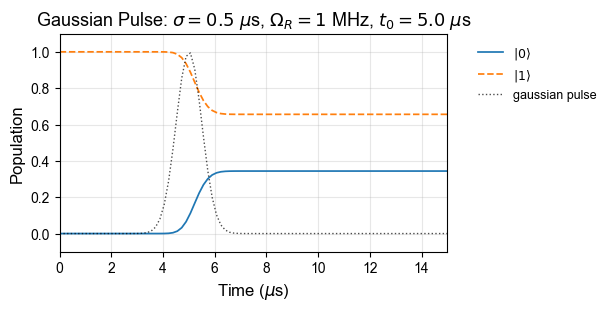

In [19]:
# the pulse shapes
pulse_dict = {
  'gaussian_pulse': {
    'data': gaussian_pulse, 
    'args': Omega01_pulse_args, 
    'label': 'gaussian pulse', 
    'style': 'Gaussian_pulse'
  },
}

# the population evolution
pop_list = [result.expect[0], result.expect[1]] # pop of |0>, |1>
legend_list = [r"$|0\rangle$", r"$|1\rangle$"]

# plot
plt.rcParams.update(plt_config)
fig, ax = plt.subplots(figsize=(6, 3), sharex=True, sharey=True, constrained_layout=True)
plot_population_evolution(
    ax,
    tlist,
    pop_list,
    legend_list,
    plot_pulse = True,
    pulse_dict = pulse_dict,
    title = rf"Gaussian Pulse: $\sigma={sigma}$ $\mu$s, $\Omega_{{R}}={Omega_Rabi}$ MHz, $t_0={t0}$ $\mu$s",
    xlabel = r"Time ($\mu$s)",
    ylabel = "Population",
    log_scale = False
)

<Axes: title={'center': 'Gaussian Pulse: $\\sigma=0.5$ $\\mu$s, $\\Omega_{R}=1$ MHz, $t_0=5.0$ $\\mu$s'}, xlabel='Time ($\\mu$s)', ylabel='$\\log_{10}$(Population)'>

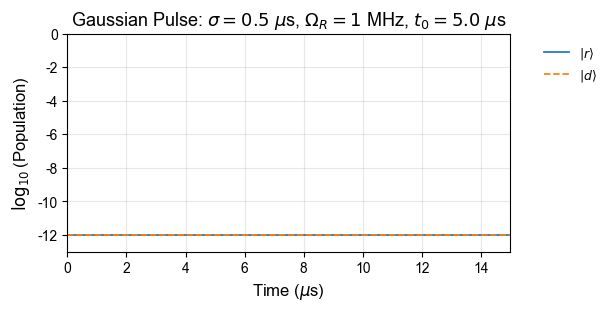

In [18]:
# the population evolution
pop_list = [result.expect[2], result.expect[3]] # pop of |d>, |r>
legend_list = [r"$|r\rangle$", r"$|d\rangle$"]

# plot
plt.rcParams.update(plt_config)
fig, ax = plt.subplots(figsize=(6, 3), sharex=True, sharey=True, constrained_layout=True)
plot_population_evolution(
    ax,
    tlist,
    pop_list,
    legend_list,
    plot_pulse = False,
    pulse_dict = {},
    title = rf"Gaussian Pulse: $\sigma={sigma}$ $\mu$s, $\Omega_{{R}}={Omega_Rabi}$ MHz, $t_0={t0}$ $\mu$s",
    xlabel = r"Time ($\mu$s)",
    ylabel = "Population",
    log_scale = True,
    ylim=[-13, 0]
)

#### Observations from Population Dynamics

**Key Findings:**
1. **No significant leakage observed**: The population remains almost entirely within the computational subspace $\{|0\rangle, |1\rangle\}$
2. **Negligible Rydberg/auxiliary state population**: As shown in the log-scale plot, populations in $|r\rangle$ and $|d\rangle$ states are extremely small ($\sim 10^{-12}$)
3. **Clean population transfer**: The atom's state oscillates purely between $|0\rangle$ and $|1\rangle$

**Physical Interpretation:**
- Since $\Omega_r = 0$ and $\Delta_r = 0$, there is no direct coupling to the Rydberg state $|r\rangle$
- The Gaussian pulse $\Omega_{01}(t)$ only drives transitions within the computational basis
- Even with Lindblad operators ($\gamma_r \neq 0$), leakage is minimal for this pulse configuration
- This validates using the 2×2 computational subspace for fidelity calculations

### `Exercise 1 - X gate`
For a fixed pulse width $\sigma = 1\ \mu s$ and different values of the Rabi frequency $\Omega_0 = \{ 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5 \}$ MHz, plot the population of the $|1\rang$ state versus time.

Since $\sigma$ is fixed, the time scale for each case is the same

In [48]:
%reset
%reload_ext autoreload
%autoreload 2

from common_imports import *

#### Set up parameters
Pulse, Time List, Hamiltonian, Lindblad

In [49]:
time_unit = 1 # [\mu s]

# gaussian Pulse parameters
# pulse width
sigma = 1 * time_unit # [\mu s]
# Rabi frequency
Omega_Rabi_list = np.linspace(0, 1.75, 8).tolist() # [MHz]
# pulse center
scale_t0 = 10 # multiplier
t0 = scale_t0 * sigma

Omega01_pulse_args = {"sigma": sigma, "t0": t0, "amp_Omega_01": 0}

# the time list
num_widths = 30
scale_tlist = np.linspace(0, num_widths, num_widths * 3)
tlist = scale_tlist * sigma

# scaled Gaussian pulse shape
scale_pulse_shape = gaussian_pulse(scale_tlist, sigma=1, t0=scale_t0, amp_Omega_01=1)

#### Set up parameters
Hamiltonian, Lindblad

In [50]:
# Hamiltonian parameters
atom0_ham_params = dict(
  Omega_01 = (gaussian_pulse, Omega01_pulse_args),  # Tuple: (function, args) 
  delta_1 = 0, 
  Omega_r = 0,  # Tuple: (function, args)
  Delta_r = 0 # Tuple: (function, args)
)

# Lindblad parameters
lindblad_params = dict(
  gamma_r = 1 / 540, # 0 : no decay
  b_0r = 1/16, 
  b_1r = 1/16, 
  b_dr = 7/8
)

#### Basis and Operators

In [51]:
# single atom basis ( four level : |0>, |1>, |r>, |d> )
state0, state1, stater, stated = make_fock_basis_states(1, 4)

# list of wanted operators
expect_list = [
  state0 * state0.dag(),
  state1 * state1.dag(),
  stater * stater.dag(),
  stated * stated.dag(),
]

#### Run Simulations

In [52]:
# initial state
# psi0 = state0
psi0 = state1

# store results
res_list = []
for Omega_Rabi in Omega_Rabi_list:
  Omega01_pulse_args["amp_Omega_01"] = Omega_Rabi

  # construct Hamiltonian
  H0, collapse_list = construct_TD_SAHam(atom0_ham_params, lindblad_params)
  
  # simulate the dynamics
  result = mesolve(H0, psi0, tlist, collapse_list, expect_list, 
                   options={"store_final_state": 1, "store_states": 0})

  res_list.append(result)

d:\anaconda3\envs\my_qiskit\Lib\site-packages\qutip\solver\solver_base.py:583: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


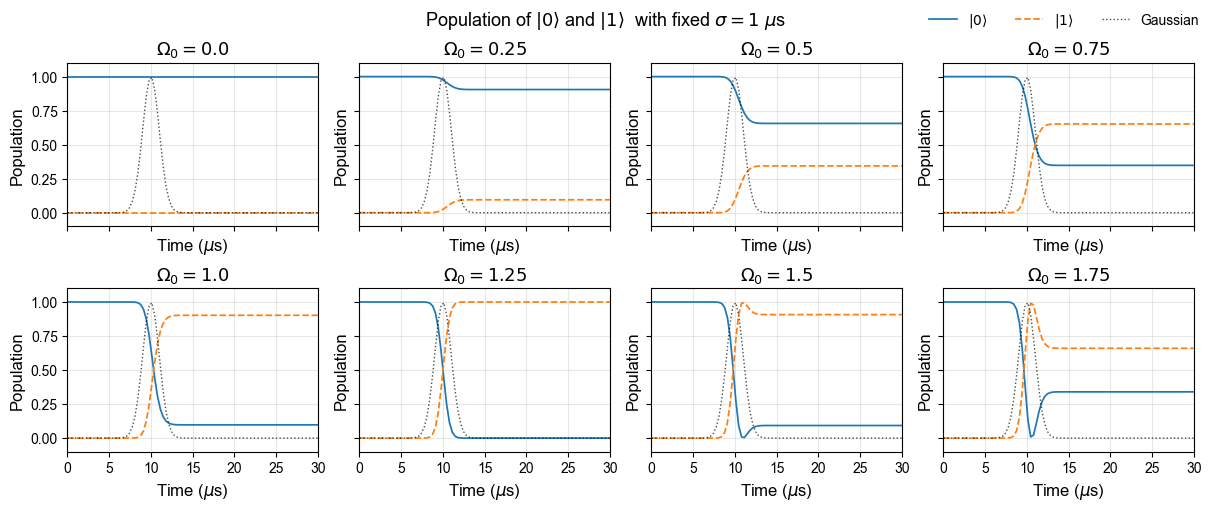

In [53]:
# the population dict
pop_dict_list = [
    {'result': res, 'indices': [0, 1], 'labels': [r'$|0\rangle$', r'$|1\rangle$'], 'sub_title': rf"$\Omega_{{0}}={Omega_Rabi}$"}
    for res, Omega_Rabi in zip(res_list, Omega_Rabi_list)
]

# global pulse dict
global_pulse_dict = {
    'gaussian_pulse': {
        'data': scale_pulse_shape,  
        'label': 'Gaussian', 
        'style': 'Gaussian_pulse'
    }
}

# plotting multiple population evolutions
plt.rcParams.update(plt_config)

fig, axes = plt.subplots(2, 4, figsize=(12, 5), sharex=True, sharey=True, constrained_layout=True)
axes = axes.ravel()

fig = plot_multiple_population_evolution(
    fig,
    axes,
    scale_tlist,
    pop_dict_list,
    suptitle = r"Population of $|0\rangle$ and $|1\rangle$ " + " with fixed "rf"$\sigma={sigma}$ $\mu$s",
    global_plot_pulse=True,
    global_pulse_dict=global_pulse_dict
  )

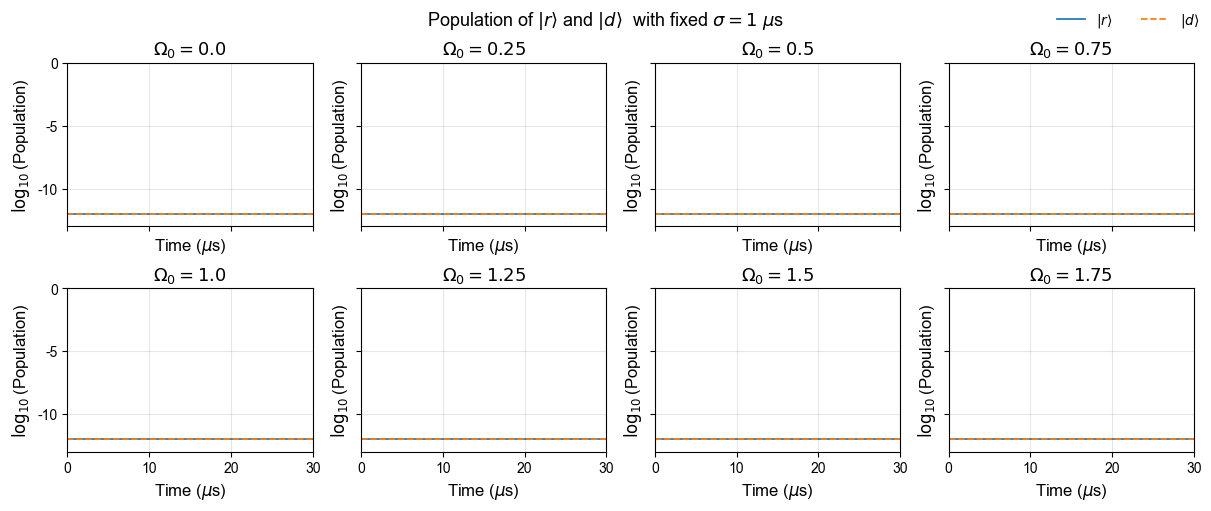

In [54]:
# the population dict
pop_dict_list = [
    {
        'result': res, 
        'indices': [2, 3], 
        'labels': [r'$|r\rangle$', r'$|d\rangle$'], 
        'sub_title': rf"$\Omega_{{0}}={Omega_Rabi}$",
        'log_scale': True,
        'ylim': (-13,0)
    }
    for res, Omega_Rabi in zip(res_list, Omega_Rabi_list)
]

# plotting multiple population evolutions
plt.rcParams.update(plt_config)

fig, axes = plt.subplots(2, 4, figsize=(12, 5), sharex=True, sharey=True, constrained_layout=True)
axes = axes.ravel()

fig = plot_multiple_population_evolution(
    fig,
    axes,
    scale_tlist,
    pop_dict_list,
    suptitle = r"Population of $|r\rangle$ and $|d\rangle$ " + " with fixed "rf"$\sigma={sigma}$ $\mu$s",
    global_plot_pulse=False,
    global_pulse_dict={}
  )

#### Observations for Fixed $\sigma = 1\ \mu s$ with Varying $\Omega_0$

**Population Dynamics in Computational Subspace:**
1. **Complete population transfer**: At optimal parameters ( $\Omega_0 \sim 1.25$ ), nearly complete transfer $|1\rangle \rightarrow |0\rangle$ is achieved, while at other parameters, this transfer is partial.

**Leakage to Auxiliary States:**
1. **Extremely small populations**: As shown in the log-scale plot, $|r\rangle$ and $|d\rangle$ populations remain below $10^{-12}$
2. **No significant leakage**: The system stays confined to the computational subspace $\{|0\rangle, |1\rangle\}$
3. **Validation**: This confirms that for $\Omega_r = 0$ and $\Delta_r = 0$, there is no effective coupling to Rydberg states

**Physical Insight:**
- The absence of leakage validates the two-level approximation for this pulse configuration
- Spontaneous emission effects are negligible on the timescale of the gate operation
- This justifies computing fidelity using only the 2×2 computational subspace

### `Fidelity Calculation for this case`

#### Construct Target Gate
here, it is the sigma x gate, but we need to embed it into a four-dimensional Hilbert space

In [55]:
# target gate
target_gate = sigmax()

#### Initial states for fidelity calculations

In [56]:
num_qubits = 1
dim_qubits = 2**num_qubits
dim_atom = 4 ** num_qubits
# initial state list for gate fidelity computation
psi0_list = make_initial_list_for_gate_fidelity(num_qubits, dim_atom)
qs0_list = make_initial_list_for_gate_fidelity(num_qubits, dim_qubits)
comp_indices = [0, 1] # indices of the computational basis states in the single-atom four-level system

#### Run Simulation

In [57]:
# store fidelity results
fidelity_arith_list = []
fidelity_geom_list = []
fidelity_mixed_list = []

for Omega_Rabi in Omega_Rabi_list:
  Omega01_pulse_args["amp_Omega_01"] = Omega_Rabi

  # construct Hamiltonian
  H0, collapse_list = construct_TD_SAHam(atom0_ham_params, lindblad_params)
  
  # compute the state fidelities
  state_fidelity_list, _ = compute_state_fidelity(
    qs0_list,
    target_gate, 
    H0, 
    collapse_list, 
    tlist,
    psi0_list=psi0_list,
    comp_indices=comp_indices,
    expect_list=None
  )

  # compute different types of gate fidelities
  fidelity_mixed, fidelity_geom, fidelity_arith = compute_gate_fidelity_mixed(
    state_fidelity_list, dim_qubits, True
  )
  fidelity_mixed_list.append(fidelity_mixed)
  fidelity_geom_list.append(fidelity_geom)
  fidelity_arith_list.append(fidelity_arith)

d:\anaconda3\envs\my_qiskit\Lib\site-packages\qutip\core\data\expm.py:139: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  return Dense(scipy.linalg.sqrtm(matrix.as_ndarray()))


#### Plot fidelity vs parameters

<Axes: title={'center': 'X Gate Infidelity vs $\\Omega_R$ with fixed $\\sigma=1$ $\\mu$s'}, xlabel='$\\Omega_R$ (MHz)', ylabel='Infidelity'>

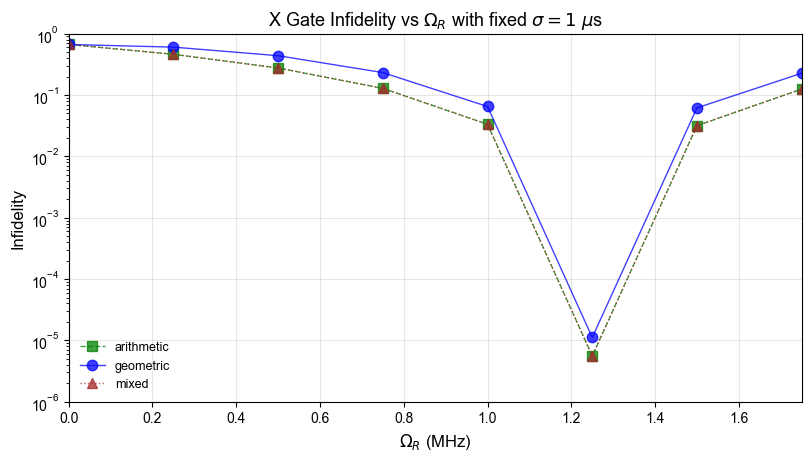

In [58]:
legend_list = ['arithmetic', 'geometric', 'mixed']

# plot
plt.rcParams.update(plt_config)

fig, ax = plt.subplots(figsize=(8, 4.5), sharex=True, sharey=True, constrained_layout=True)

plot_fidelity_vs_parameter(
    ax = ax,
    param_list = Omega_Rabi_list,
    fidelity_list = [fidelity_arith_list, fidelity_geom_list, fidelity_mixed_list],
    legend_list = legend_list,
    title = rf"X Gate Infidelity vs $\Omega_R$ with fixed $\sigma={sigma}$ $\mu$s",
    xlabel = r"$\Omega_R$ (MHz)",
    ylabel = "Infidelity",
    use_infidelity = True,
    log_scale = True,
    xlim = None,
    ylim = (1e-6, 1),
    grid_alpha = 0.3,
    show_legend = True,
    plotting_style_list = [plotting_styles['fidelity_style_a'], 
                           plotting_styles['fidelity_style_b'], 
                           plotting_styles['fidelity_style_c']]
)

### Conclusion :
- The fidelity reaches its minimum at $\Omega_R =1.25 \approx \sqrt{\frac{\pi}{2}}$, which is expected.
- In this case, I think there is no error channel which leads to leakage. I think $|r\rang$ does not play an important role here. First of all, in the Hamiltonian, there is no coupling between $|0\rang,|1\rang$ and $|r\rang$ since $\Omega_r, \Delta_r$ is set to be zero. And also the Lindblad operators does not work in this case since I have set $\gamma_r = 0$ and found the results does not change at all.

### `Exercise 1 - X gate`
For a fixed Rabi frequency $\Omega_0 = 1 $ MHz and different values of the pulse wideth $\sigma = \{ 0.5, 1, 1.5, 2, 4, 8 \} \mu s$, plot the population of the $|1\rang$ state versus time.

In [59]:
%reset
%reload_ext autoreload
%autoreload 2

from common_imports import *

In [61]:
time_unit = 1 # [us]

# gaussian pulse parameters
# pulse width
sigma_list = [0.5, 0.75, 1, 1.25, 1.5, 2, 4, 8] * time_unit # in microseconds
# Rabi frequency
Omega_Rabi = 1 # in MHz
# pulse center
scale_t0 = 10 # multiplier for sigma to get pulse center
t0 = scale_t0 * time_unit # away from time zero

Omega01_pulse_args = {"sigma": np.nan, "t0": np.nan, "amp_Omega_01": Omega_Rabi}

# time list
num_widths = 20
scale_tlist = np.linspace(0, num_widths, num_widths * 3)

# scaled Gaussian pulse shape
scale_pulse_shape = gaussian_pulse(scale_tlist, sigma=1, t0=scale_t0, amp_Omega_01=1)

#### Basis and Operators

In [66]:
# single atom basis ( four level : |0>, |1>, |r>, |d> )
state0, state1, stater, stated = make_fock_basis_states(1, 4)

# list of wanted operators
expect_list = [
  state0 * state0.dag(),
  state1 * state1.dag(),
  stater * stater.dag(), 
  stated * stated.dag(),
]

#### Set up parameters
Hamiltonian, Lindblad

In [67]:
# Hamiltonian parameters
atom0_ham_params = dict(
  Omega_01 = (gaussian_pulse, Omega01_pulse_args),  # Tuple: (function, args) 
  delta_1 = 0, 
  Omega_r = 0,  # Tuple: (function, args)
  Delta_r = 0 # Tuple: (function, args)
)

# Lindblad parameters
lindblad_params = dict(
  gamma_r = 1 / 540, 
  b_0r = 1/16, 
  b_1r = 1/16, 
  b_dr = 7/8
)

#### Run Simulations

In [68]:
# initial state
psi0 = state0
# psi0 = state1

# store results
res_list = []
for sigma in sigma_list:
  # pulse center
  t0 = scale_t0 * sigma # away from time zero
  Omega01_pulse_args["sigma"] = sigma
  Omega01_pulse_args["t0"] = t0

  # time list
  tlist = scale_tlist * sigma

  # construct Hamiltonian
  H, c_op_list = construct_TD_SAHam(atom0_ham_params, lindblad_params)

  # simulate the dynamics
  result = mesolve(H, psi0, tlist, c_op_list, e_ops=expect_list, 
                   options={"store_final_state": 1, "store_states": 0})
  
  res_list.append(result)

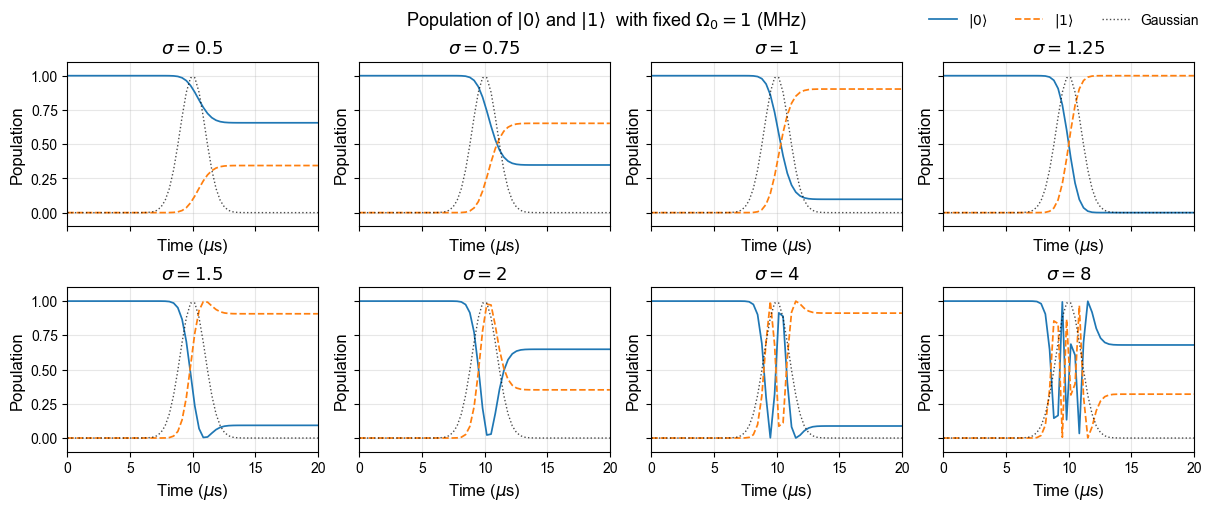

In [69]:
# the population dict
pop_dict_list = [
    {'result': res, 'indices': [0, 1], 'labels': [r'$|0\rangle$', r'$|1\rangle$'], 'sub_title': rf"$\sigma={sigma}$"}
    for res, sigma in zip(res_list, sigma_list)
]

# global pulse dict
global_pulse_dict = {
    'gaussian_pulse': {
        'data': scale_pulse_shape,  
        'label': 'Gaussian', 
        'style': 'Gaussian_pulse'
    }
}

# plotting multiple population evolutions
plt.rcParams.update(plt_config)

fig, axes = plt.subplots(2, 4, figsize=(12, 5), sharex=True, sharey=True, constrained_layout=True)
axes = axes.ravel()

fig = plot_multiple_population_evolution(
    fig,
    axes,
    scale_tlist,
    pop_dict_list,
    suptitle = r"Population of $|0\rangle$ and $|1\rangle$ " + " with fixed "rf"$\Omega_{0}={Omega_Rabi}$ (MHz)",
    global_plot_pulse=True,
    global_pulse_dict=global_pulse_dict
  )

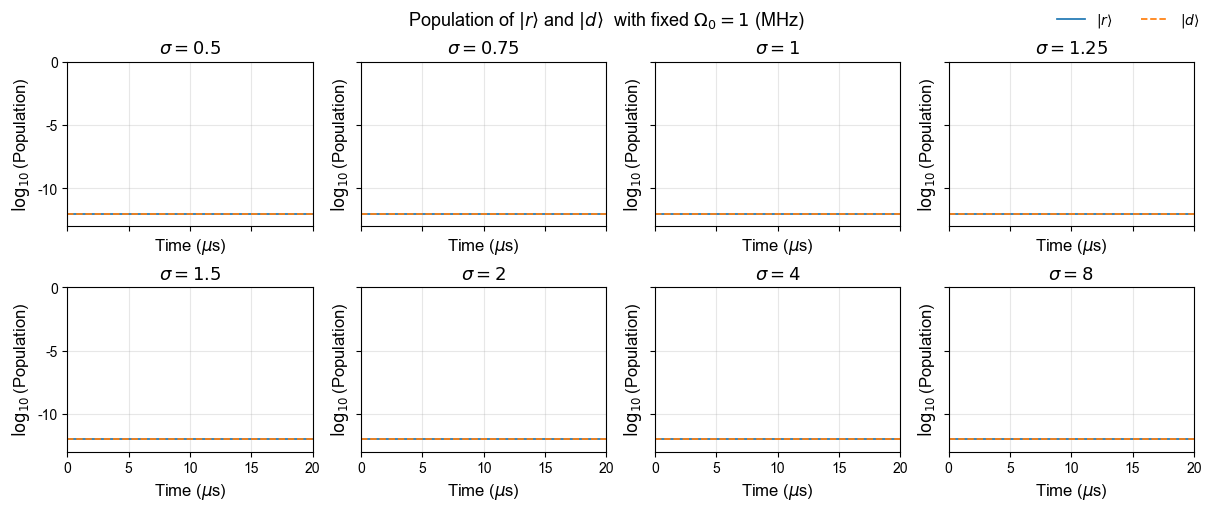

In [71]:
# the population dict
pop_dict_list = [
    {
        'result': res, 
        'indices': [2, 3], 
        'labels': [r'$|r\rangle$', r'$|d\rangle$'], 
        'sub_title': rf"$\sigma={sigma}$",
        'log_scale': True,
        'ylim': (-13,0)
    }
    for res, sigma in zip(res_list, sigma_list)
]

# plotting multiple population evolutions
plt.rcParams.update(plt_config)

fig, axes = plt.subplots(2, 4, figsize=(12, 5), sharex=True, sharey=True, constrained_layout=True)
axes = axes.ravel()

fig = plot_multiple_population_evolution(
    fig,
    axes,
    scale_tlist,
    pop_dict_list,
    suptitle = r"Population of $|r\rangle$ and $|d\rangle$ " + " with fixed "rf"$\Omega_{0}={Omega_Rabi}$ (MHz)",
    global_plot_pulse=False,
    global_pulse_dict={}
  )

### Conclusion : For $\pi$-pulse, we have the relation $\Omega_0\cdot\sigma = \sqrt{\frac{\pi}{2}}$, 
in other notebook, I have checked that for different values of $\Omega_{01}$, the optimized $\sigma$ does follow this relation

#### Qubit Dynamics on the Bloch Sphere

**Bloch Sphere Representation:**
The Bloch sphere provides a geometric visualization of single-qubit states. Any pure state of a two-level system can be represented as a point on the unit sphere with coordinates $(x, y, z)$ corresponding to expectation values $\langle \sigma_x \rangle$, $\langle \sigma_y \rangle$, $\langle \sigma_z \rangle$.

**X-Gate on Bloch Sphere:**
- The X-gate (σ_x) performs a π rotation around the x-axis
- Initial state $|0\rangle$ (north pole: z=+1) → Final state $|1\rangle$ (south pole: z=-1)
- Trajectory: Great circle passing through both poles

**Implementation:**
- Use optimal π-pulse parameters: $\Omega_0 \cdot \sigma = \sqrt{\frac{\pi}{2}}$
- Track expectation values of Pauli operators ($\sigma_x$, $\sigma_y$, $\sigma_z$) during evolution
- Visualize the qubit state trajectory on the Bloch sphere

**Expected Behavior:**
For initial state $|0\rangle$, the Gaussian pulse should drive a clean rotation from the north pole to the south pole, demonstrating the X-gate operation in the geometric picture.

In [72]:
time_unit = 1 # [\mu s]

# gaussian Pulse parameters
# pulse width
sigma = 0.5 * time_unit # in [\mu s]
# Rabi frequency
Omega_Rabi = np.sqrt(np.pi/2) / sigma # [MHz]
# pulse center
scale_t0 = 10 # multiplier
t0 = scale_t0 * sigma # away from time zero
Omega01_pulse_args = {"sigma": sigma, "t0": t0, "amp_Omega_01": Omega_Rabi}

# time list
num_widths = 30
scale_tlist = np.linspace(0, num_widths, num_widths * 3)
tlist = scale_tlist * sigma

# Hamiltonian parameters
atom0_ham_params = dict(
  Omega_01 = (gaussian_pulse, Omega01_pulse_args),  # Tuple: (function, args) 
  delta_1 = 0, 
  Omega_r = 0,  # Tuple: (function, args)
  Delta_r = 0 # Tuple: (function, args)
)

# Lindblad parameters
lindblad_params = dict(
  gamma_r = 1 / 540, 
  b_0r = 1/16, 
  b_1r = 1/16, 
  b_dr = 7/8
)

# single atom basis ( four level : |0>, |1>, |r>, |d> )
state0, state1, stater, stated = make_fock_basis_states(1, 4)

H0, collapse_list = construct_TD_SAHam(atom0_ham_params, lindblad_params)

# list of wanted operators
pauli_op_list = [
  state0 * state1.dag() + state1 * state0.dag(), # sigma_x
  - 1j * (state0 * state1.dag() - state1 * state0.dag()), # sigma_y
  state0 * state0.dag() - state1 * state1.dag() # sigma_z
]

# expect_list = pauli_op_list

In [73]:
qs0 = basis(2,0)
psi0 = state0

# simulate the dynamics
result = mesolve(H=H0, rho0=psi0, tlist=tlist, c_ops=collapse_list, e_ops=pauli_op_list, 
                 options={"store_final_state": 1, "store_states": 0})
# rho_ss = steadystate(H, c_op_list)
exp_sx_circ, exp_sy_circ, exp_sz_circ = result.expect
exp_sx_circ, exp_sy_circ, exp_sz_circ = (
  np.array(exp_sx_circ),
  np.array(exp_sy_circ),
  np.array(exp_sz_circ),
)

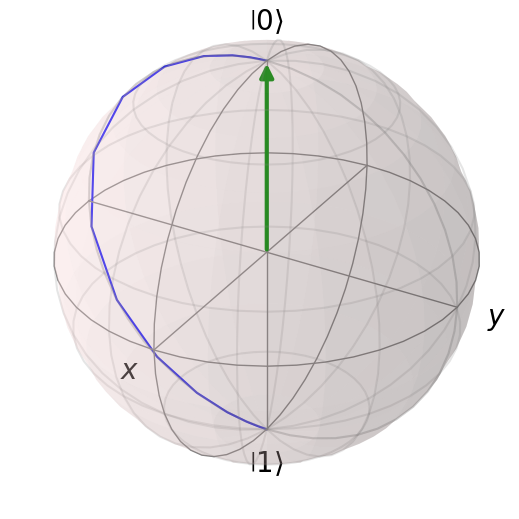

In [74]:
# Create Bloch Sphere plot
sphere = Bloch()
sphere.add_points([exp_sx_circ, exp_sy_circ, exp_sz_circ], meth='l')
sphere.add_states(qs0)
sphere.show()